In [170]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from utils import pretreat_data
import seaborn as sns
sns.set_style("darkgrid")
colors = sns.color_palette("colorblind6")

# Path to the data
train_path = "../data/ClimateTrain.csv"
test_path = "../data/ClimateTest.csv"

# Read as pandas dataframe and transform dates to datetime
train_df_raw = pd.read_csv(train_path)
train_df_raw['date'] = pd.to_datetime(train_df_raw['date'])

test_df_raw = pd.read_csv(test_path)
test_df_raw['date'] = pd.to_datetime(test_df_raw['date'])

# Plot description
train_df_raw.describe()
test_df_raw.describe()

,meantemp,humidity,wind_speed,meanpressure
count,114.000000,114.000000,114.000000,114.000000
mean,21.713079,56.258362,8.143924,1004.035090
std,6.360072,19.068083,3.588049,89.474692
min,11.000000,17.750000,1.387500,59.000000
25%,16.437198,39.625000,5.563542,1007.437500
50%,19.875000,57.750000,8.069444,1012.739316
75%,27.705357,71.902778,10.068750,1016.739583
max,34.500000,95.833333,19.314286,1022.809524


## Pretreat the data

In [171]:
train_df, test_df, norm_stats = pretreat_data(train_df_raw, test_df_raw)

Pre-treating data...
{'meantemp': {'mean': 25.495520655761762, 'std': 7.348102725432476}, 'humidity': {'mean': 60.749546508715525, 'std': 16.79073354358986}, 'wind_speed': {'mean': 6.634903591220332, 'std': 4.24227584263327}, 'meanpressure': {'mean': 1008.2364359217448, 'std': 7.4472597886225085}}


## Plot to double check that data looks okay

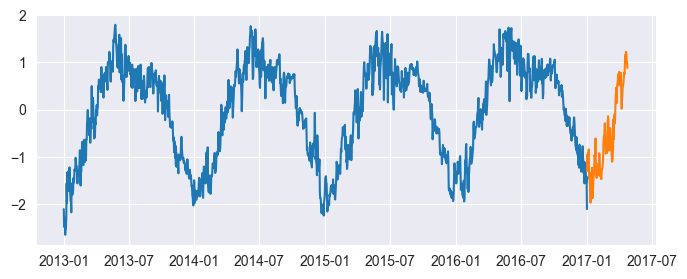

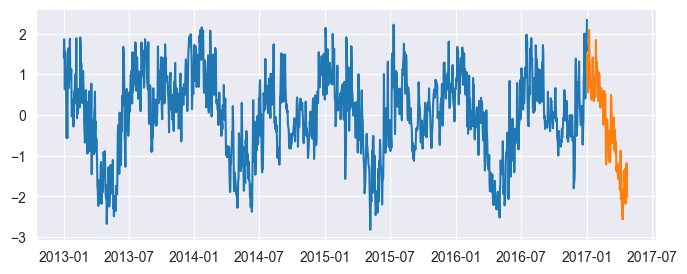

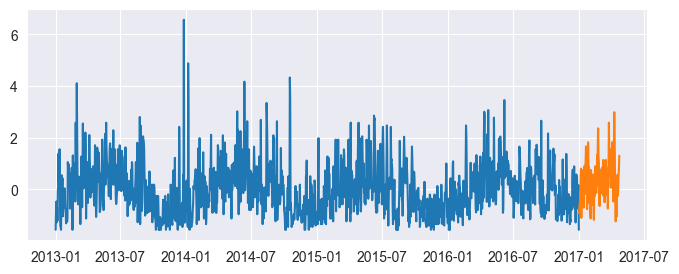

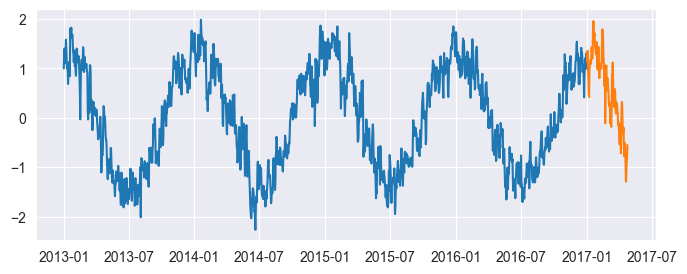

In [172]:
for col in train_df.columns[1:]:
    plt.figure(figsize=(8,3))
    plt.plot(train_df["date"], train_df[col])
    plt.plot(test_df["date"], test_df[col])
    

# Metrics

In [173]:
def RMSE(gt, pred):
    return np.sqrt(((pred - gt)**2).mean())

def SMAPE(gt, pred):
    return ( (np.abs(pred - gt)) / ((np.abs(gt) + np.abs(pred))/2) ).mean()
    

# 1.0 Baseline mode

RMSE:  7.409645611322448
SMAPE:  0.11375341652809505


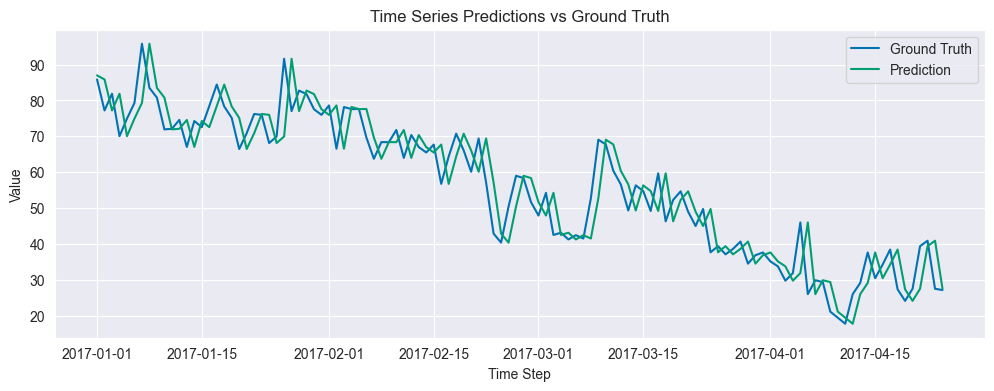

In [174]:
horizon = 1
test_start_date = test_df["date"].loc[0]
test_window_date = test_start_date - pd.Timedelta(days=horizon)
filtered_train_df = train_df[(train_df['date'] >= test_window_date) & (train_df['date'] < test_start_date)]
test_df_altered = pd.concat([filtered_train_df, test_df], ignore_index=True)


test_df_altered["humidity"] = test_df_altered["humidity"]*norm_stats["humidity"]["std"] + norm_stats["humidity"]["mean"]
pred = []
gt = []
for i in range(len(test_df_altered)-horizon):
    pred.append(test_df_altered["humidity"].iloc[i])
    gt.append(test_df_altered["humidity"].iloc[i+horizon])

# Squeeze the extra dimensions away and turn to numpy
gt = np.array(gt)
pred = np.array(pred)

# Check that metrics give zero
# gt = gt[:-horizon]
# pred = pred[horizon:]

mean_rmse = RMSE(gt, pred)
mean_smape = SMAPE(gt, pred)
print("RMSE: ", mean_rmse)
print("SMAPE: ", mean_smape)

plt.figure(figsize=(12,4))
plt.plot(test_df["date"], gt, label="Ground Truth", color=colors[0])
plt.plot(test_df["date"], pred, label="Prediction", color=colors[1])

# Add labels, legend, and grid
plt.title("Time Series Predictions vs Ground Truth")
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.legend()
plt.grid("on")

plt.show()

# 1.1 RNN, LSTM, and Transformer models

In [ ]:
from utils import rolling_train_valid_split
from dataset import TimeSeriesDataset
from torch import nn, optim
from torch.utils.data import DataLoader
import torch

torch.manual_seed(42)
# use importlib magic so that if changes is made in the models, no need to restart the jupyter notebook
from importlib import reload
import models
import trainer
import transformer_model
reload(models)
reload(trainer)
reload(transformer_model)

from trainer import train, validate
from transformer_model import TransformerForecaster, DecoderForecaster
from models import RNN_model, LSTM_model

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# number of points
window_size = 20
hidden_size = 128
embed_dim = 128
n_layers = 2
output_size = 1

date_as_var = True
if date_as_var:
    input_size = 6
else:
    input_size = 4

# Define model
model_type = "RNN"
match model_type:
    case "RNN":
        model = RNN_model(hidden_size=hidden_size, embed_dim = embed_dim, n_layers=n_layers, input_size=input_size, out_features=output_size, dropout_p=0.2)
    case "LSTM":
        model = LSTM_model(hidden_size=hidden_size, embed_dim = embed_dim, n_layers=n_layers, input_size=input_size, out_features=output_size, dropout_p=0.2)
    case "Transformer":
        model = model = TransformerForecaster(hidden_size=hidden_size, embed_dim = embed_dim, 
                              encoder_heads=4, encoder_depth=4,
                              decoder_heads=4, decoder_depth=4, 
                              input_size=input_size, out_features=output_size, dropout_p=0.2)
    case "Decoder":
        model = DecoderForecaster(hidden_size=hidden_size, embed_dim = embed_dim, 
                        decoder_heads=2, decoder_depth=1, 
                        input_size=input_size, out_features=output_size, dropout_p=0.2)
    case _:
             "Something's wrong with the internet"

model = model.to(device)

# Define batch size
batch_size = 128
n_epochs = 100
lr = 0.0001

criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr, weight_decay=0.03)

# Set Training Horizon
horizon = 1

## 1.1 Train

In [176]:
# Generate rolling train-validation splits
loss_history = {0: {"train": [], "valid": []}, 
                1: {"train": [], "valid": []}, 
                2: {"train": [], "valid": []},
                3: {"train": []}}
for i, (train_data, valid_data) in enumerate(rolling_train_valid_split(train_df, months=6, window_size=window_size, horizon=horizon)):
    print("Training fold ", i)
    train_dataset = TimeSeriesDataset(df=train_data, window_size=window_size, horizon=horizon, date_as_var=date_as_var)
    if valid_data is not None:
        valid_dataset = TimeSeriesDataset(df=valid_data, window_size=window_size, horizon=horizon, date_as_var=date_as_var)
    
    # Initialize the dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size)
    avg_val_loss = 0
    for epoch in range(n_epochs):
        avg_train_loss = train(model, train_loader, criterion, optimizer, device, model_type)
        
        loss_history[i]["train"].append(avg_train_loss)
        
        if valid_data is not None:
            avg_val_loss = validate(model, valid_loader, criterion, device, model_type)
            loss_history[i]["valid"].append(avg_val_loss)
        print(f"Epoch {epoch+1}/{n_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    

Training fold  0
Epoch 1/100, Train Loss: 1.1547, Val Loss: 1.5691
Epoch 2/100, Train Loss: 1.1591, Val Loss: 1.5689
Epoch 3/100, Train Loss: 1.1552, Val Loss: 1.5686
Epoch 4/100, Train Loss: 1.1571, Val Loss: 1.5684
Epoch 5/100, Train Loss: 1.1555, Val Loss: 1.5682
Epoch 6/100, Train Loss: 1.1576, Val Loss: 1.5680
Epoch 7/100, Train Loss: 1.1571, Val Loss: 1.5678
Epoch 8/100, Train Loss: 1.1570, Val Loss: 1.5676
Epoch 9/100, Train Loss: 1.1555, Val Loss: 1.5674
Epoch 10/100, Train Loss: 1.1551, Val Loss: 1.5672
Epoch 11/100, Train Loss: 1.1584, Val Loss: 1.5670
Epoch 12/100, Train Loss: 1.1554, Val Loss: 1.5668
Epoch 13/100, Train Loss: 1.1560, Val Loss: 1.5666
Epoch 14/100, Train Loss: 1.1562, Val Loss: 1.5664
Epoch 15/100, Train Loss: 1.1515, Val Loss: 1.5662
Epoch 16/100, Train Loss: 1.1549, Val Loss: 1.5660
Epoch 17/100, Train Loss: 1.1507, Val Loss: 1.5658
Epoch 18/100, Train Loss: 1.1546, Val Loss: 1.5656
Epoch 19/100, Train Loss: 1.1520, Val Loss: 1.5654
Epoch 20/100, Train Los

## Plot train and validation losses

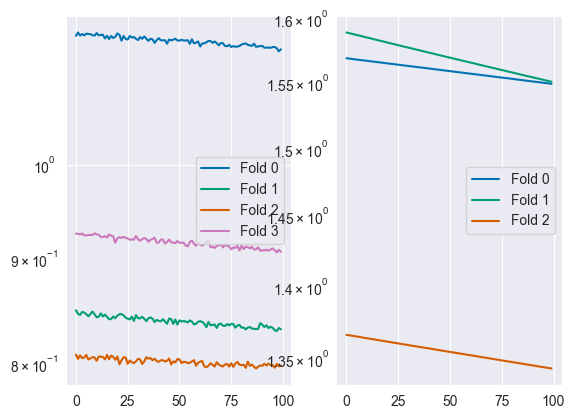

In [177]:
fig, ax = plt.subplots(1,2)
for i in range(4):
    ax[0].plot(loss_history[i]["train"], label=f"Fold {i}", color=colors[i])
    ax[0].legend()
    if "valid" in loss_history[i]:
        ax[1].plot(loss_history[i]["valid"], label=f"Fold {i}", color=colors[i])
        ax[1].legend()
    ax[0].semilogy()
    ax[1].semilogy()

Alternative plot

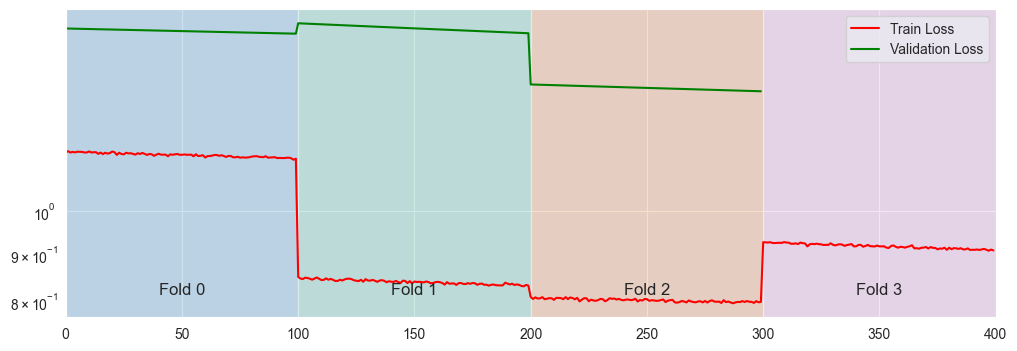

In [178]:
lt = [l for i in range(4) for l in loss_history[i]["train"]]
lv = [l for i in range(3) for l in loss_history[i]["valid"]]
plt.figure(figsize=(12,4))
plt.plot(lt, label="Train Loss", color="r")
plt.plot(lv, label="Validation Loss", color="g")
ylims = plt.gca().get_ylim()
plt.axvspan(0, 100, facecolor=colors[0], alpha=0.2)
plt.text(40, 0.5*max(ylims), "Fold 0", fontsize=12)
plt.axvspan(100, 200, facecolor=colors[1], alpha=0.2)
plt.text(140, 0.5 * max(ylims), "Fold 1", fontsize=12)
plt.axvspan(200, 300, facecolor=colors[2], alpha=0.2)
plt.text(240, 0.5 * max(ylims), "Fold 2", fontsize=12)
plt.axvspan(300, 400, facecolor=colors[3], alpha=0.2)
plt.text(340, 0.5 * max(ylims), "Fold 3", fontsize=12)
plt.xlim(0, 400)
plt.legend()
plt.semilogy()
plt.show()

## 1.2 Test

In [179]:
# Add The required windows size to the test df so that we can start predicting from the beginning
test_horizon = 1
test_start_date = test_df["date"].loc[0]
test_window_date = test_start_date - pd.Timedelta(days=window_size+test_horizon-1)
filtered_train_df = train_df[(train_df['date'] >= test_window_date) & (train_df['date'] < test_start_date)]
test_df_altered = pd.concat([filtered_train_df, test_df], ignore_index=True)

test_dataset = TimeSeriesDataset(df=test_df_altered, window_size=window_size, horizon=test_horizon, date_as_var=date_as_var)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

len(test_dataset)
print("first target", test_dataset[0][1])
# print(f"{window_size+test_horizon}th window humidity", test_dataset[window_size+test_horizon][0][0] )
test_dataset[1][0]

first target tensor(1.4961)


tensor([[-8.7717e-01,  9.5318e-02, -7.5547e-01,  9.2162e-01, -3.0411e-01,
          9.5264e-01],
        [-9.4446e-01, -1.2736e-01,  3.2833e-01,  1.2215e+00, -2.8772e-01,
          9.5772e-01],
        [-9.9738e-01, -2.4564e-01,  7.6475e-01,  1.1320e+00, -2.7123e-01,
          9.6251e-01],
        [-1.3149e+00,  1.5057e-01, -6.4075e-01,  1.4155e+00, -2.5467e-01,
          9.6703e-01],
        [-1.0881e+00,  1.5719e-01,  2.2789e-02,  1.1697e+00, -2.3803e-01,
          9.7126e-01],
        [-1.2809e+00,  2.2585e-01, -5.0461e-02,  1.3222e+00, -2.2133e-01,
          9.7520e-01],
        [-1.0395e+00, -2.7720e-01,  8.9089e-01,  1.2343e+00, -2.0455e-01,
          9.7886e-01],
        [-7.7510e-01, -7.2756e-01, -7.2367e-01,  9.3505e-01, -1.8772e-01,
          9.8222e-01],
        [-1.0133e+00, -3.8411e-01, -7.3590e-01,  9.9132e-01, -1.7083e-01,
          9.8530e-01],
        [-1.1173e+00, -1.7226e-01, -1.0701e-01,  1.0617e+00, -1.5389e-01,
          9.8809e-01],
        [-1.3535e+00,  8.3084e

In [180]:
model.eval()
total_rmse, total_smape = 0, 0
results = {"pred": [], "gt": []}
with torch.no_grad(): # Iterate
    for idx in range(len(test_dataset)):
        inputs, targets = test_dataset[idx]
        inputs, targets = inputs.unsqueeze(0).to(device), targets.to(device)
        if model_type == "RNN" or model_type == "LSTM":
            # Initialize the hidden state
            prev_state = model.init_state(inputs.size(0), device)
        
            # Pass the input through the model
            outputs, _ = model(inputs, prev_state)
        else:
            # Shift the targets to the right so the input and the correct target match
            input = inputs[:, :-1, :]
            target = inputs[:, 1:, :]
            outputs = model(input, target)

        # Squeeze away the extra dimensions
        outputs = outputs.squeeze()
        targets = targets.squeeze()
        
        results["gt"].append(targets.cpu())
        results["pred"].append(outputs.cpu())
    

# Squeeze the extra dimensions away and turn to numpy
gt = np.array(results["gt"])
pred = np.array(results["pred"])

gt = gt*norm_stats["humidity"]["std"] + norm_stats["humidity"]["mean"]
pred = pred*norm_stats["humidity"]["std"] + norm_stats["humidity"]["mean"]

mean_rmse = RMSE(gt, pred)
mean_smape = SMAPE(gt, pred)
print("RMSE: ", mean_rmse)
print("SMAPE: ", mean_smape)


RMSE:  19.347317
SMAPE:  0.30951574


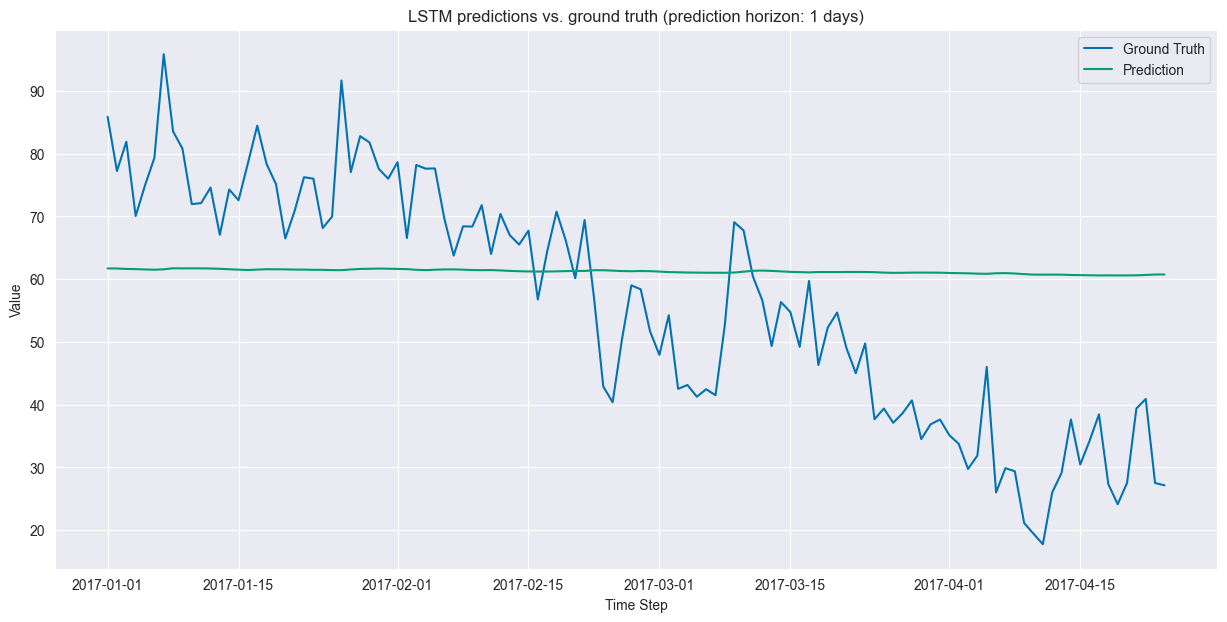

In [181]:

# Plot the ground truth and predictions
plt.figure(figsize=(15, 7))
plt.plot(test_df["date"], gt, label="Ground Truth", color=colors[0])
plt.plot(test_df["date"], pred, label="Prediction", color=colors[1])
# Add labels, legend, and grid
plt.title(f"{model_type} predictions vs. ground truth (prediction horizon: {test_horizon} days)")
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.legend()
plt.grid("on")
plt.show()